In [ ]:
import cv2
import numpy as np
from tensorflow import keras
from PIL.Image import fromarray
import matplotlib.pyplot as plt

In [ ]:
import os
from keras.preprocessing.image import img_to_array

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
paths = ['/content/gdrive/MyDrive/Colab Notebooks/Dataset/Covid Dataset/non-COVID/', '/content/gdrive/MyDrive/Colab Notebooks/Dataset/Covid Dataset/COVID/']

In [ ]:
X = []
y = []

for label, path in  enumerate(paths):
    for img_path in os.listdir(path):
        X.append(img_to_array(fromarray(cv2.resize(cv2.imread(os.path.join(path, img_path), cv2.IMREAD_GRAYSCALE), (256,256)))))
        y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
X /= 255.0

In [ ]:
print(X.shape)
print(y.shape)

(2481, 256, 256, 1)
(2481,)


In [ ]:
print(X.min())
print(X.max())

0.0
1.0


In [ ]:
print(y.min())
print(y.max())

0
1


In [ ]:
import seaborn
import pandas

Text(0.5, 1.0, 'Frequency of covid/non-covid patients')

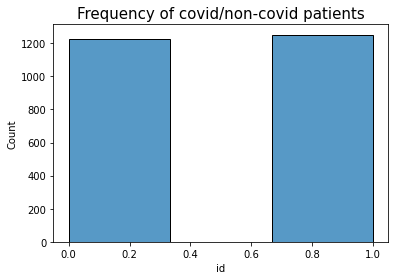

In [ ]:
import seaborn
import pandas
seaborn.histplot(pandas.DataFrame({'id' : y}), x = 'id',bins = 3)
plt.title('Frequency of covid/non-covid patients', fontsize = 15)

In [ ]:
info = {
    0 : 'Non Covid Scan',
    1 : 'Covid Scan'
}

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2232, 256, 256, 1)
(2232,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(249, 256, 256, 1)
(249,)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_gen = ImageDataGenerator(rotation_range = 5, zoom_range = [0.9, 1.2], horizontal_flip = True, height_shift_range = [-5,5], width_shift_range = [-5,5])

In [ ]:
train_gen.fit(X_train)

In [ ]:
pointer = train_gen.flow(X_train, y_train)

In [ ]:
a, b = pointer.next()

In [ ]:
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization

In [ ]:
def conv_layer (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), padding = 'same', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2, 2)))
    
    return model

def dens_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    return model

In [ ]:
def cnn (filter1, filter2, hidden1, hidden2) :
    
    model = Sequential([
        
        Input((256,256,1,)),
        conv_layer(filter1),
        conv_layer(filter2),
        Flatten(),
        dens_layer(hidden1),
        dens_layer(hidden2),
        
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
    return model

In [ ]:
model = cnn(2**3,
            2**3,
            2**6,
            2**5)

In [ ]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 8)       112       
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 8)         616       
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 sequential_2 (Sequential)   (None, 64)                2097472   
                                                                 
 sequential_3 (Sequential)   (None, 32)                2208      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,100,441
Trainable params: 2,100,217
No

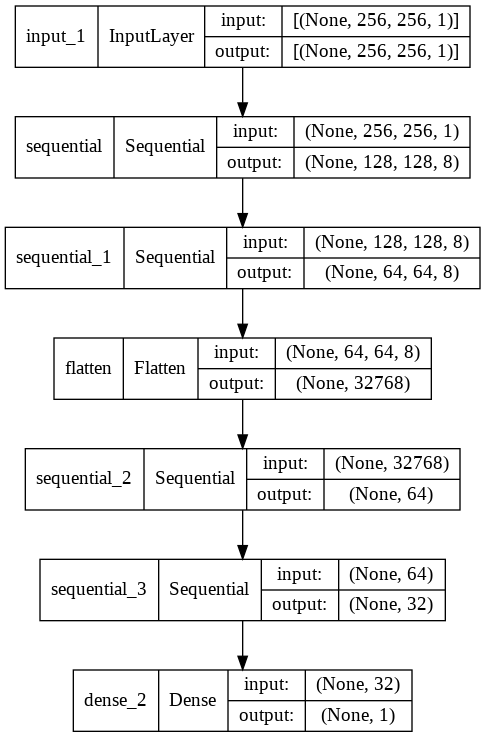

In [ ]:
keras.utils.plot_model(model, './covid_model.png', show_shapes = True)

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
checkp = ModelCheckpoint('./covid-model.h5', save_best_only = True, monitor = 'val_loss', verbose = 1)

#the training below took 3 hours 27 minutes to complete

In [ ]:
history = model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 100, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 2.1751 - accuracy: 0.7195
Epoch 00001: val_loss improved from inf to 2.70762, saving model to ./covid-model.h5
35/35 [==============================] - 104s 3s/step - loss: 2.1751 - accuracy: 0.7195 - val_loss: 2.7076 - val_accuracy: 0.5382
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 1.4762 - accuracy: 0.8553
Epoch 00002: val_loss improved from 2.70762 to 2.66401, saving model to ./covid-model.h5
35/35 [==============================] - 101s 3s/step - loss: 1.4762 - accuracy: 0.8553 - val_loss: 2.6640 - val_accuracy: 0.5382
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 1.1013 - accuracy: 0.8768
Epoch 00003: val_loss improved from 2.66401 to 2.53666, saving model to ./covid-model.h5
35/35 [==============================] - 101s 3s/step - loss: 1.1013 - accuracy: 0.8768 - val_loss: 2.5367 - val_accuracy: 0.5382
Epoch 4/100
35/35 [==============================] - ETA: 0s -

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
model = keras.models.load_model('./covid-model.h5')

In [ ]:
y_pred = model.predict(X_test, verbose = 1)

8/8 [==============================] - 3s 360ms/step


In [ ]:
y_pred = np.around(y_pred)

In [ ]:
print(f'Number of 0 labels in test dataset : {y_test[y_test == 0].shape[0]}')
print(f'Number of 1 labels in test dataset : {y_test[y_test == 1].shape[0]}')


Number of 0 labels in test dataset : 115
Number of 1 labels in test dataset : 134


In [ ]:
print(f'Number of 0 labels in pred dataset : {y_pred[y_pred == 0].shape[0]}')
print(f'Number of 1 labels in pred dataset : {y_pred[y_pred == 1].shape[0]}')

Number of 0 labels in pred dataset : 121
Number of 1 labels in pred dataset : 128


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       115
           1       0.87      0.83      0.85       134

    accuracy                           0.84       249
   macro avg       0.84      0.84      0.84       249
weighted avg       0.84      0.84      0.84       249



In [ ]:
cm = confusion_matrix(y_test, y_pred)
disease_types = ['Covid','non-Covid']

Text(0.5, 145.31999999999996, 'Predicted')

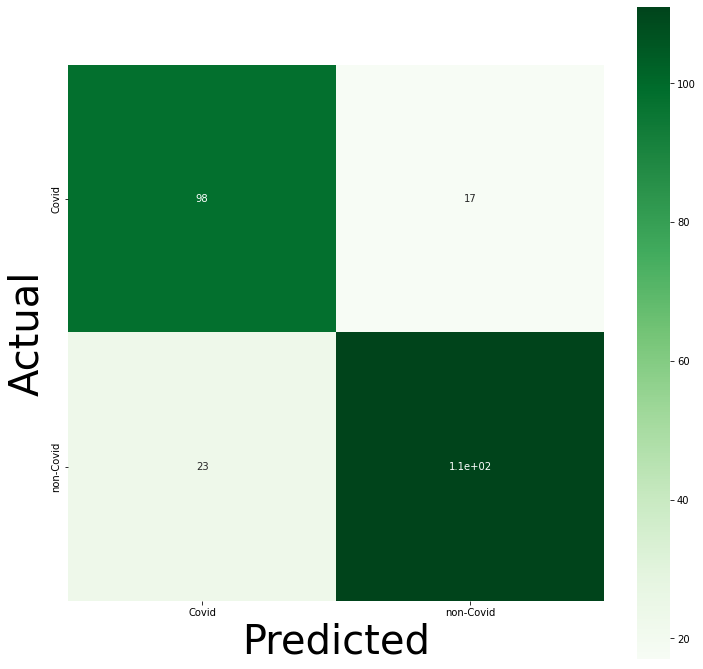

In [ ]:
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)